# Analyses de la résilience d'un essaim de nano-satellites

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist
import random
import networkx as nx
import matplotlib.pyplot as plt

from swarm_sim import *



%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
PATH = 'Traces.csv'

df = pd.read_csv(PATH, sep=',', header=None)
satellites = {}

for i in range(0,100):
    sat = df.iloc[3*i : 3*i+3].copy()
    sat['coords'] = ['x','y','z']
    satellites[i] = sat.set_index('coords', drop=True)

satellites[0]

0             1             2             3             4     \
coords                                                                         
x      -4.850747e+05 -4.937755e+05 -5.024536e+05 -5.111086e+05 -5.197401e+05   
y      -7.066530e+05 -7.201117e+05 -7.335372e+05 -7.469290e+05 -7.602864e+05   
z      -2.026363e+06 -2.019625e+06 -2.012795e+06 -2.005871e+06 -1.998855e+06   

                5             6             7             8             9     \
coords                                                                         
x      -5.283476e+05 -5.369309e+05 -5.454894e+05 -5.540229e+05 -5.625310e+05   
y      -7.736088e+05 -7.868957e+05 -8.001464e+05 -8.133603e+05 -8.265368e+05   
z      -1.991747e+06 -1.984548e+06 -1.977257e+06 -1.969876e+06 -1.962403e+06   

        ...          9990          9991          9992          9993  \
coords  ...                                                           
x       ...  1.490967e+06  1.494274e+06  1.497573e+06  1.500865e+06   
y       ...  2.218138e+06  2.223313e+06  2.228477e+06  2.233629e+06   
z       ...  3.692429e+06  3.686602e+06  3.680756e+06  3.674890e+06   

                9994          9995          9996          9997          9998  \
coords                                                                         
x       1.504149e+06  1.507425e+06  1.510693e+06  1.513954e+06  1.517206e+06   
y       2.238769e+06  2.243898e+06  2.249015e+06  2.254120e+06  2.259214e+06   
z       3.669006e+06  3.663103e+06  3.657180e+06  3.651239e+06  3.645278e+06   

                9999  
coords                
x       1.520451e+06  
y       2.264296e+06  
z       3.639299e+06  

[3 rows x 10000 columns]

In [3]:
RANGE1 = 20000
RANGE2 = 40000
RANGE3 = 60000

list_satellites = []

for i in range(len(satellites)):
    obj_sat = Node.__new__(Node)
    obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])
    list_satellites.append(obj_sat)

swarm = Swarm.__new__(Swarm)
swarm.__init__(RANGE1, list_satellites)
graph1 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE2, list_satellites)
graph2 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE3, list_satellites)
graph3 = swarm.swarm_to_nxgraph()

/tmp/ipykernel_16366/233490362.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])


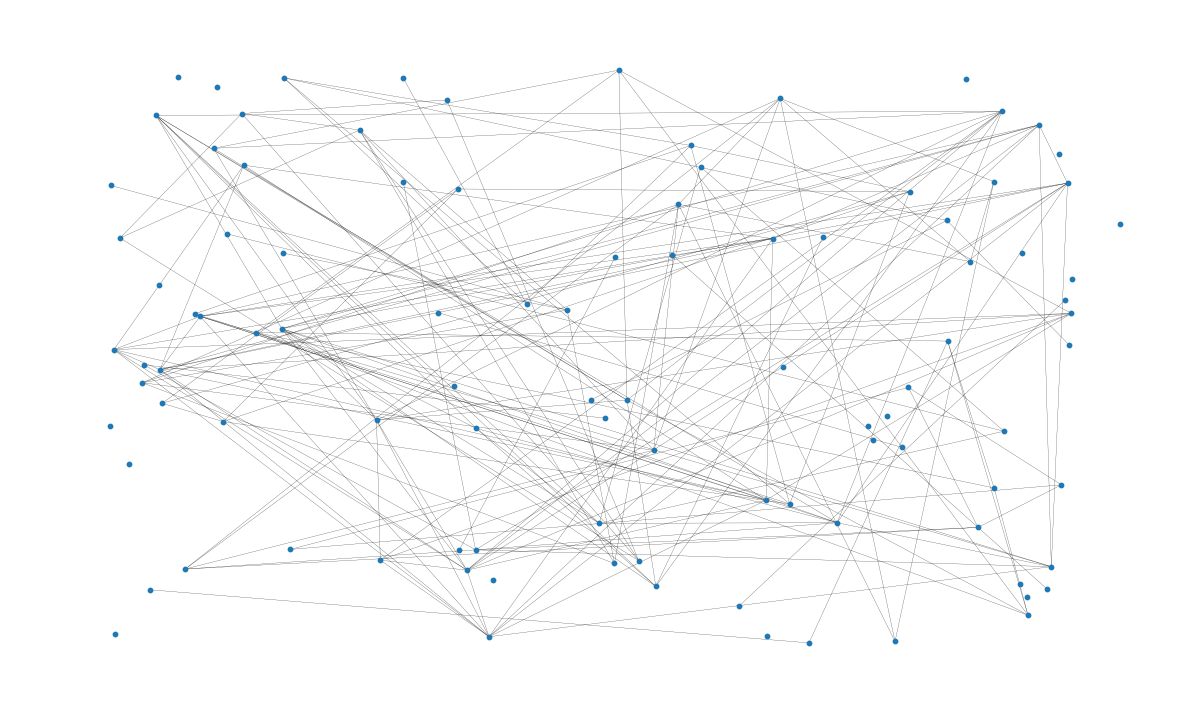

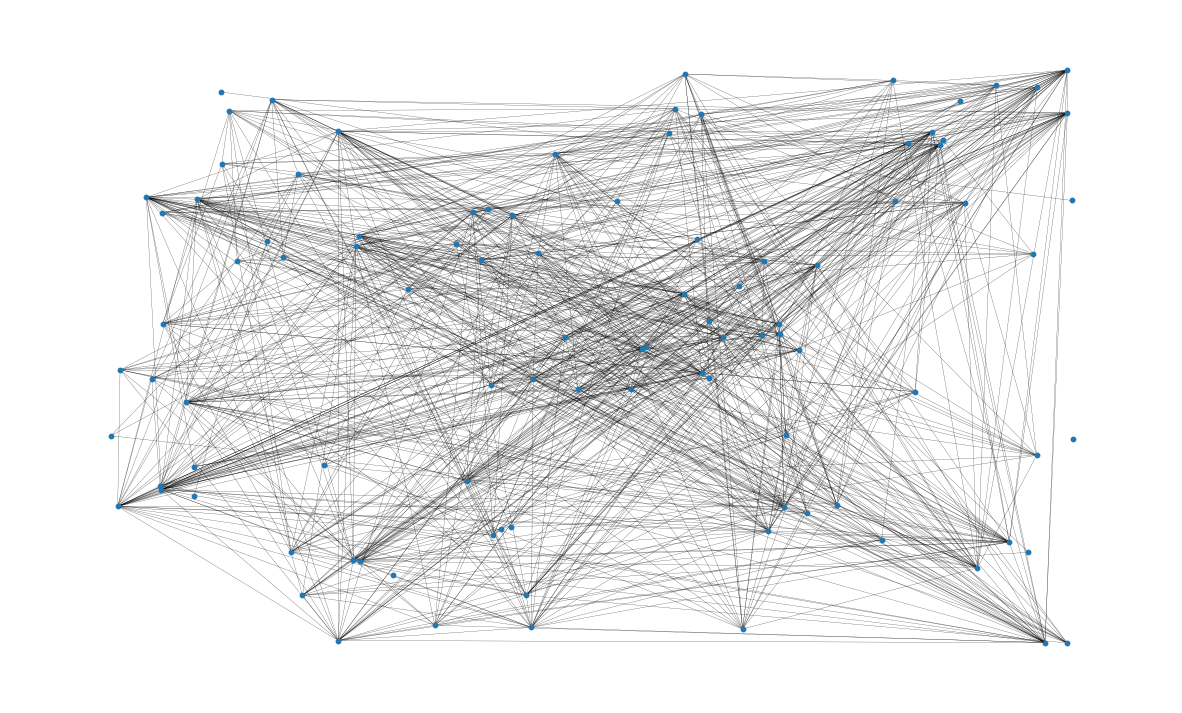

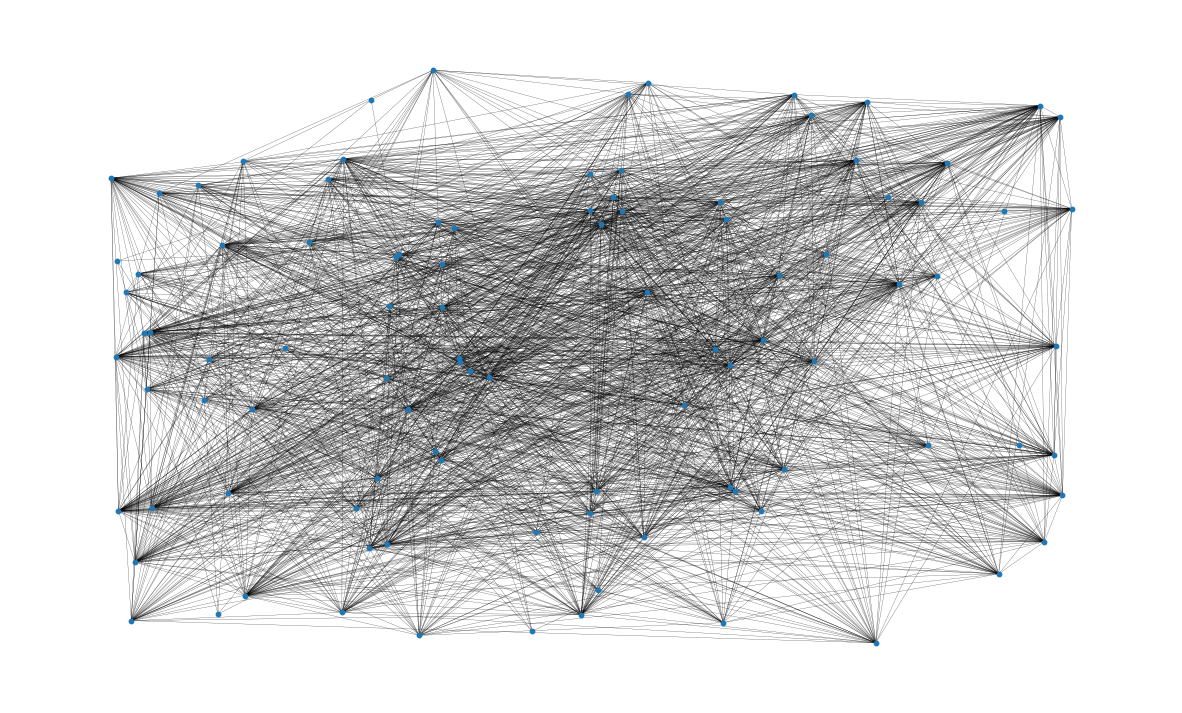

In [5]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
def afficher_graphe(graph):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")
    nx.draw_networkx(graph, pos=nx.random_layout(graph1), ax=ax, **plot_options)

afficher_graphe(graph1) #arc si distance < 20km
afficher_graphe(graph2) #arc si distance < 40km
afficher_graphe(graph3) #arc si distance < 60km

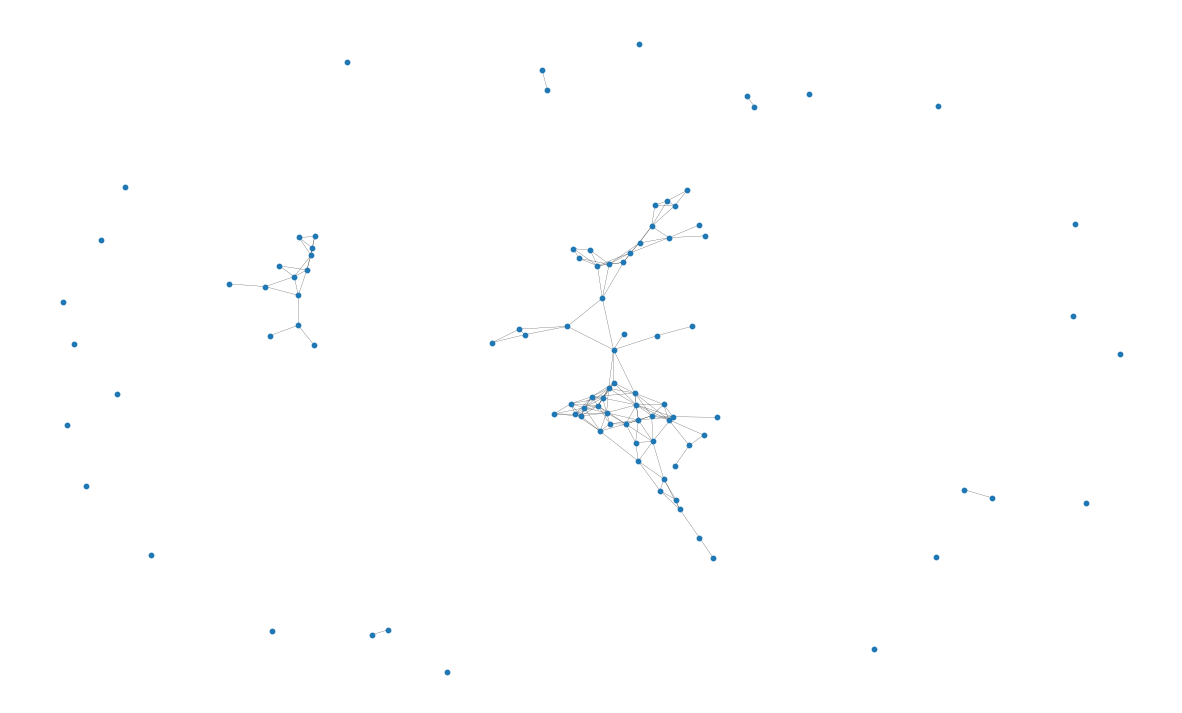

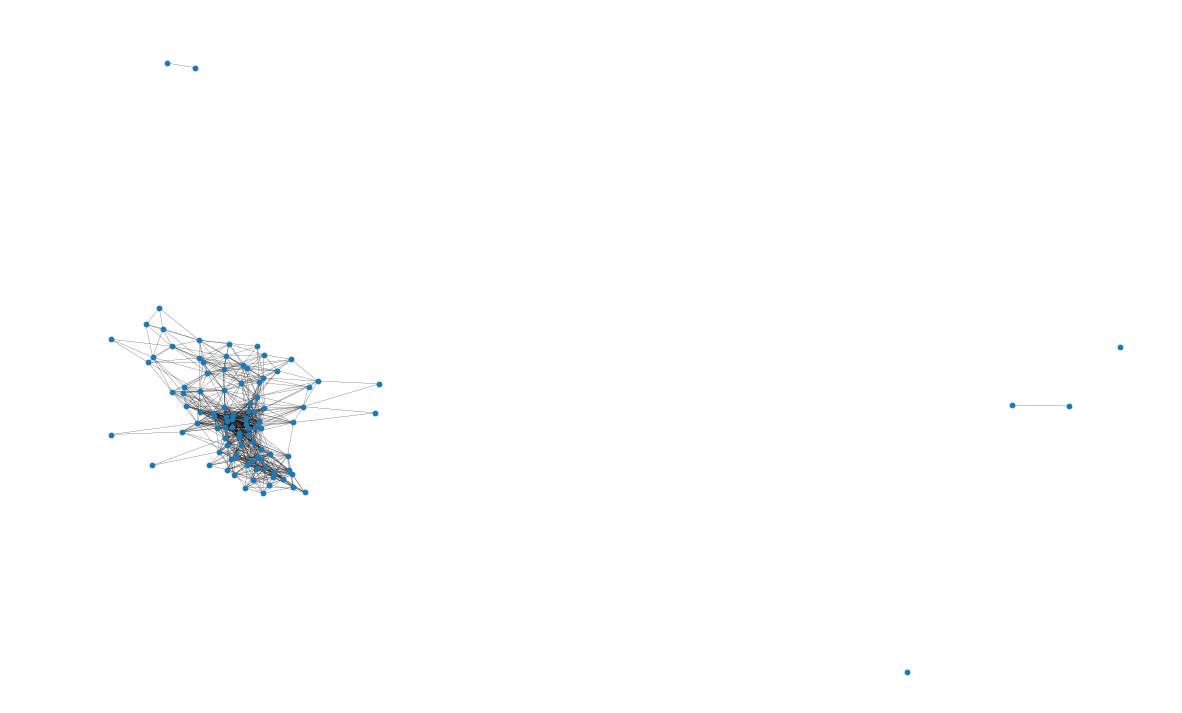

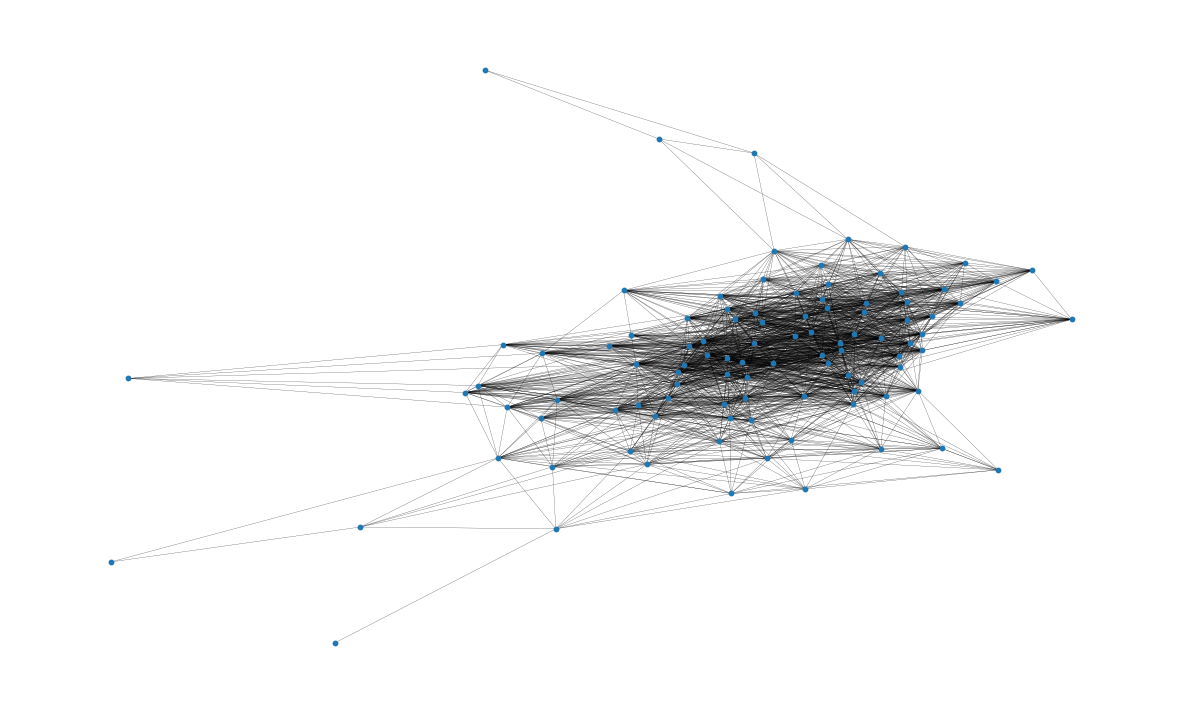

In [8]:
def afficher_graphe_avec_layout(graph):
    pos = nx.spring_layout(graph)
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")
    nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

afficher_graphe_avec_layout(graph1) #arc si distance < 20km
afficher_graphe_avec_layout(graph2) #arc si distance < 40km
afficher_graphe_avec_layout(graph3) #arc si distance < 60km

## Robert Ludo

Voir si on supprime un nanosatellite qu'est ce que ça fait

In [ ]:
def analyse_graph_on_graphobj_df(graph, nb_to_remove, seed=None, targeted=False, centrality=False, display=True):
    """
    Analyse graphique avec retour sous forme de DataFrame des métriques réseau avant/après suppression sur un graphe donné.

    Paramètres :
        - graph : objet NetworkX existant (graph1, graph2 ou graph3)
        - nb_to_remove : nombre de satellites à supprimer
        - seed : graine pour reproductibilité
        - targeted : True pour supprimer les plus connectés
        - centrality : True pour supprimer les plus centraux
        - display : affiche les graphes avant/après

    Retour :
        - DataFrame avec les métriques avant/après et la liste des satellites supprimés
    """
    random.seed(seed)
    graph_full = graph.copy()

    # Sélection des nœuds à supprimer
    if targeted:
        degrees = dict(graph_full.degree)
        to_remove = sorted(degrees, key=degrees.get, reverse=True)[:nb_to_remove]
    elif centrality:
        centrals = nx.betweenness_centrality(graph_full)
        to_remove = sorted(centrals, key=centrals.get, reverse=True)[:nb_to_remove]
    else:
        to_remove = random.sample(list(graph_full.nodes), nb_to_remove)

    # Suppression
    graph_reduced = graph_full.copy()
    graph_reduced.remove_nodes_from(to_remove)

    # Fonction pour les métriques
    def compute_metrics(G):
        return {
            "nb_nodes": G.number_of_nodes(),
            "nb_edges": G.number_of_edges(),
            "connectivity": nx.number_connected_components(G),
            "avg_degree": (sum(dict(G.degree).values()) / G.number_of_nodes()) if G.number_of_nodes() > 0 else 0,
            "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) and G.number_of_nodes() > 1 else None
        }

    metrics_before = compute_metrics(graph_full)
    metrics_after = compute_metrics(graph_reduced)

    # Affichage des graphes
    if display:
        pos = nx.spring_layout(graph_full, iterations=15, seed=1721)
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        for ax, G, title in zip(axs, [graph_full, graph_reduced], ["Avant panne", "Après panne"]):
            ax.axis("off")
            nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
            ax.set_title(title + f" - Suppression {len(to_remove)} noeuds", fontsize=14)

    # Création DataFrame
    df_result = pd.DataFrame([
        {"metric": k,
         "before": metrics_before[k],
         "after": metrics_after[k],
         "delta": (metrics_after[k] - metrics_before[k]) if metrics_after[k] is not None and metrics_before[k] is not None else None}
        for k in metrics_before
    ])
    df_result["removed_nodes"] = [to_remove] + [None] * (len(df_result) - 1)
    return df_result



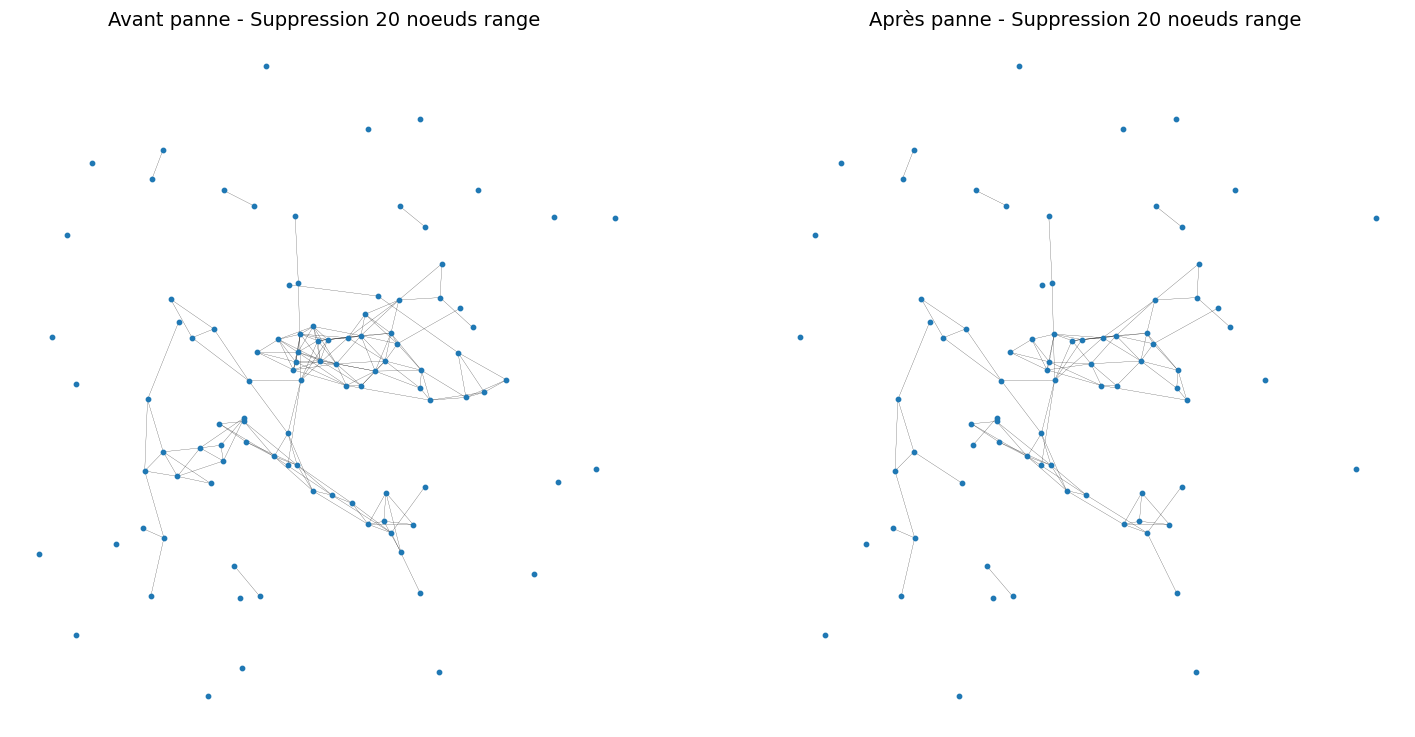

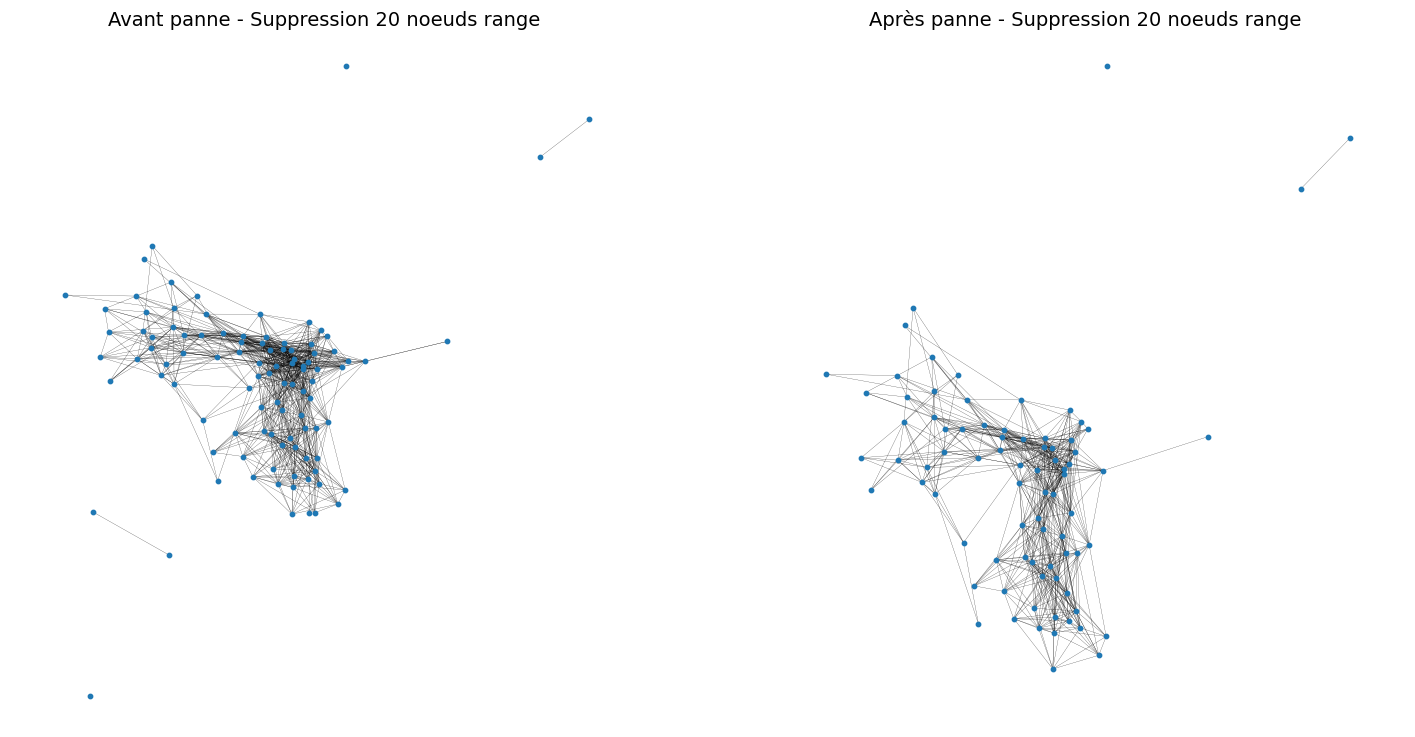

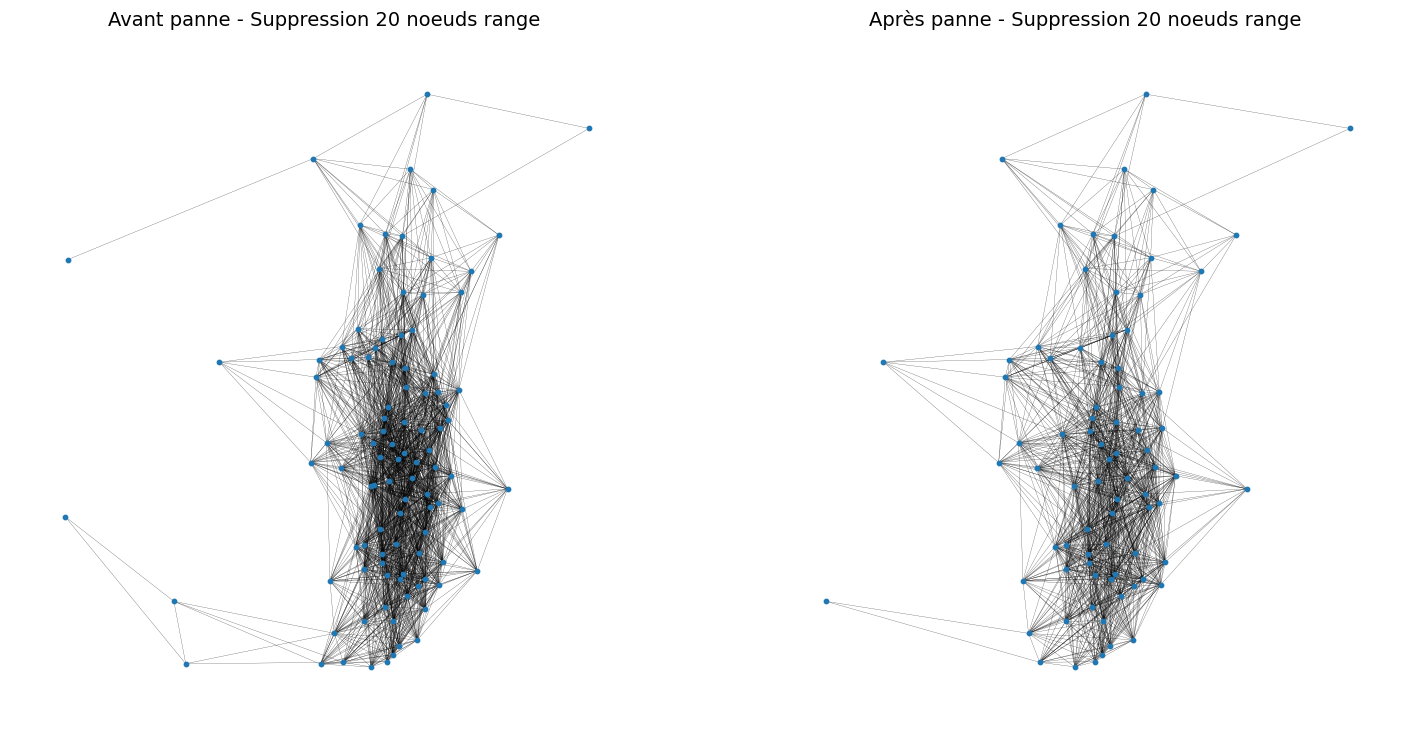

In [ ]:
df1 = analyse_graph_on_graphobj_df(graph1, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)
df2 = analyse_graph_on_graphobj_df(graph2, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)
df3 = analyse_graph_on_graphobj_df(graph3, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)


# Résilience : 

## Code algorithmes

### Redondance des chemins

In [32]:
def path_redundancy(G):
    nodes = list(G.nodes)
    total = 0
    count = 0
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            u = nodes[i]
            v = nodes[j]
            try:
                paths = list(nx.all_shortest_paths(G, source=u, target=v))
                total += len(paths)
                count += 1
            except nx.NetworkXNoPath:
                continue
    return total / count if count > 0 else 0



In [33]:
r = path_redundancy(graph1)
print("Redondance moyenne :", r)


Redondance moyenne : 3.607919687674289


### Disparité des chemins

In [29]:
def path_disparity(G):
    nodes = list(G.nodes)
    disparities = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            try:
                paths = list(nx.all_shortest_paths(G, nodes[i], nodes[j]))
                if len(paths) < 2:
                    continue
                d_uv = nx.shortest_path_length(G, nodes[i], nodes[j])
                total_diff = 0
                for p1 in paths:
                    for p2 in paths:
                        if p1 == p2: continue
                        sym_diff = len(set(p1) ^ set(p2))
                        total_diff += sym_diff / (d_uv - 1)
                disparities.append(total_diff / (len(paths)**2 - len(paths)))
            except:
                continue
    return np.mean(disparities) if disparities else 0


In [36]:
disparity = path_disparity(graph1)
print("Écart de 20km :") 
print("Disparité moyenne des chemins :", disparity)

disparity = path_disparity(graph2)
print("Écart de 40km :") 
print("Disparité moyenne des chemins :", disparity)

disparity = path_disparity(graph3)
print("Écart de 60km :")
print("Disparité moyenne des chemins :", disparity)

Disparité moyenne des chemins : 1.8480732159329898


### Criticité des noeuds 

In [34]:
def critical_nodes(G, epsilon=0.05):
    centralities = nx.betweenness_centrality(G, normalized=True)
    return [n for n, v in centralities.items() if v >= epsilon]


In [ ]:
critics1 = critical_nodes(graph1)  # epsilon = 0.05 par défaut
print("Criticité écart de 20km")
print("Noeuds critiques :", critics1)
print("Nombre de noeuds critiques :", len(critics1))

critics2 = critical_nodes(graph1)  # epsilon = 0.05 par défaut
print("Criticité écart de 40km")
print("Noeuds critiques :", critics2)
print("Nombre de noeuds critiques :", len(critics2))

critics3 = critical_nodes(graph1)  # epsilon = 0.05 par défaut
print("Criticité écart de 60km")
print("Noeuds critiques :", critics3)
print("Nombre de noeuds critiques :", len(critics3))


Noeuds critiques : [6, 7, 22, 39, 68, 70]
Nombre de noeuds critiques : 6


# Résilience ciblées

## Analyse de l'impact de la suppression des noeuds à plus haut degré

In [10]:
def list_nodes_high_degree(graph, n):
    """
    Retourne une liste des nœuds avec le plus haut degré dans le graphe donné.

    Paramètres :
        - graph : le graphe à analyser
        - n : nombre de nœuds à retourner

    Retour :
        - Liste des nœuds avec le plus haut degré
    """
    degrees = dict(graph.degree)
    return sorted(degrees, key=degrees.get, reverse=True)[:n]

def delete_nodes(graph, n):
    """
    Supprime une liste de nœuds d'un graphe.

    Paramètres :
        - graph : le graphe à modifier
        - nodes : liste des nœuds à supprimer

    Retour :
        - Graphe modifié
    """
    nodes = list_nodes_high_degree(graph, n)
    graph.remove_nodes_from(nodes)
    return graph

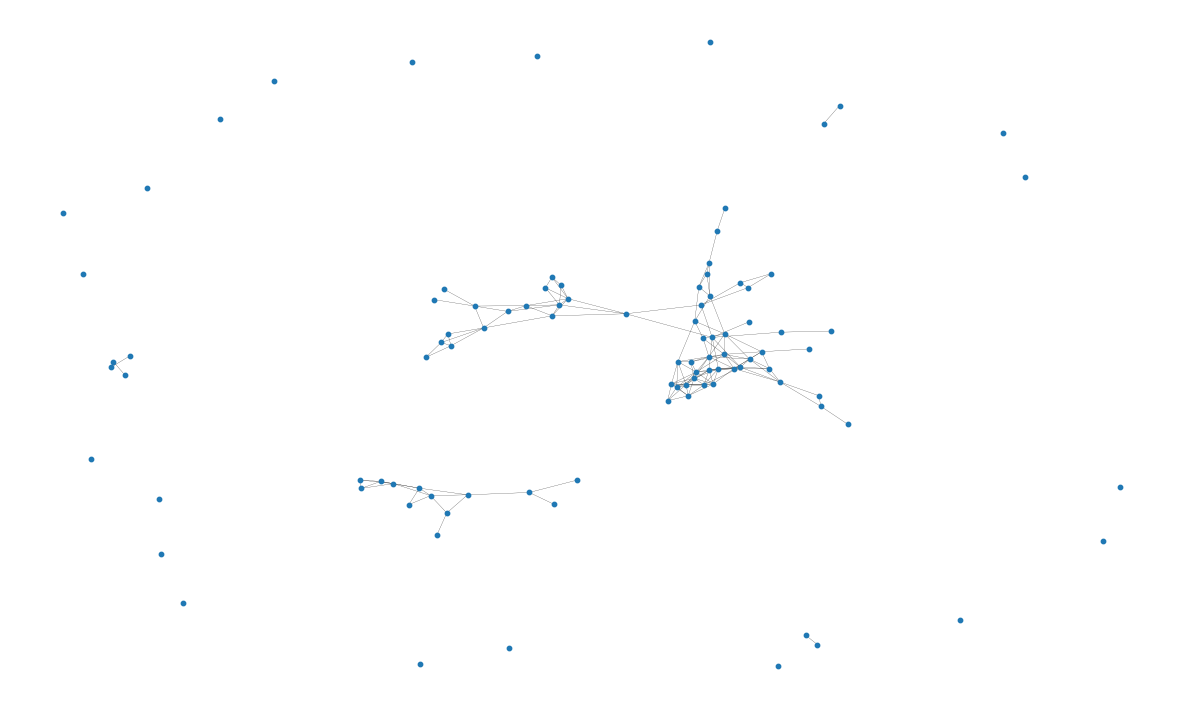

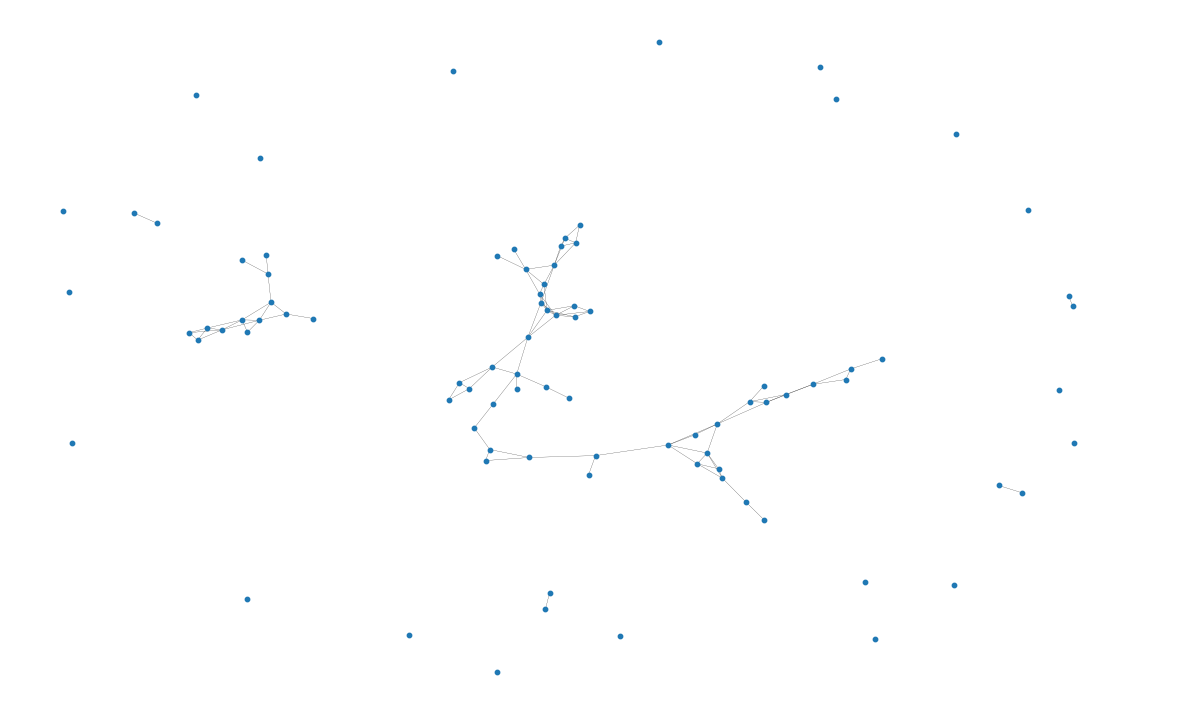

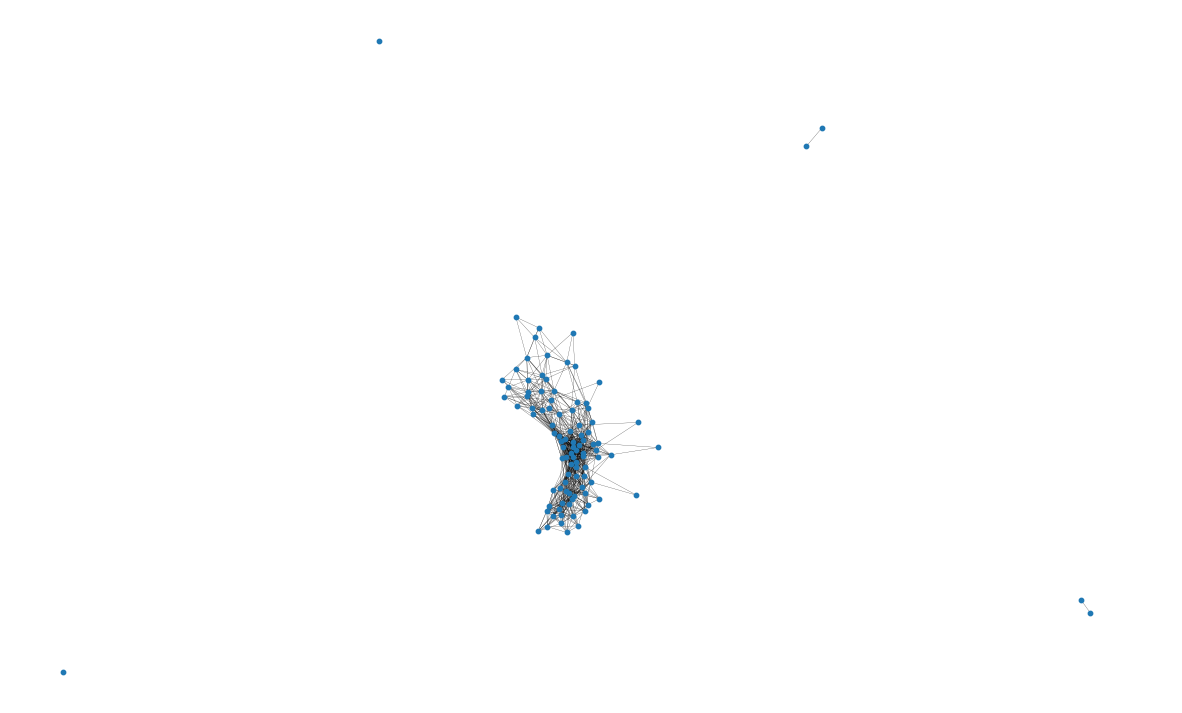

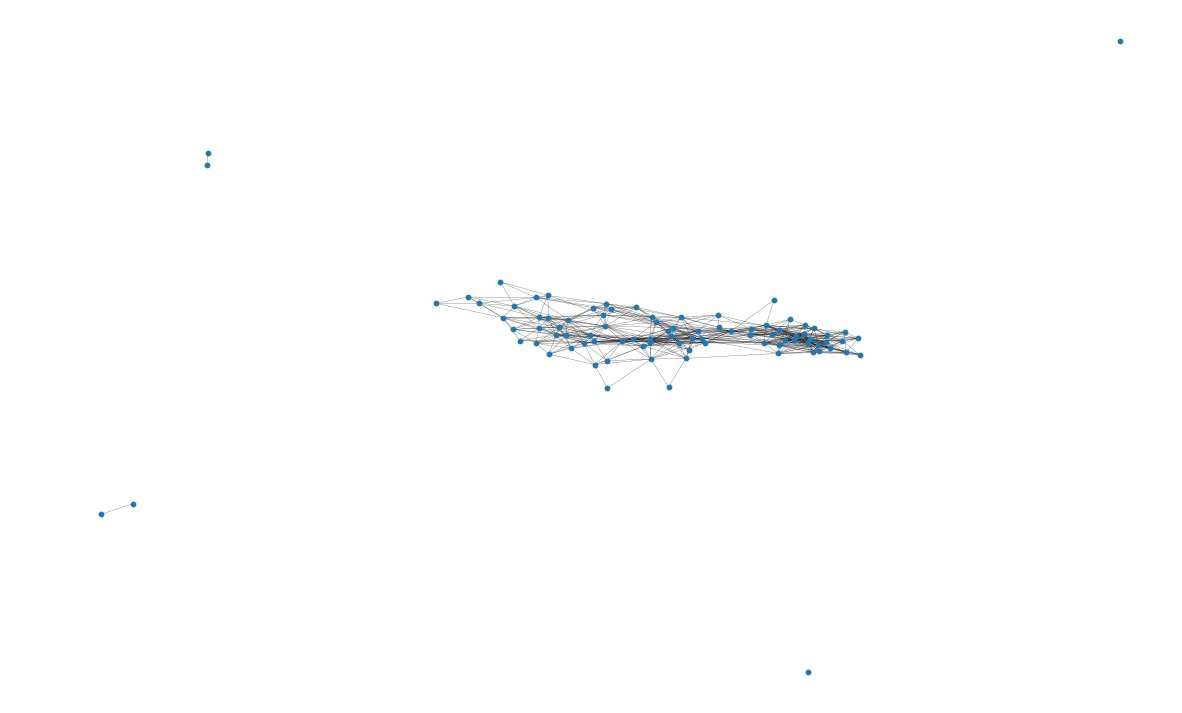

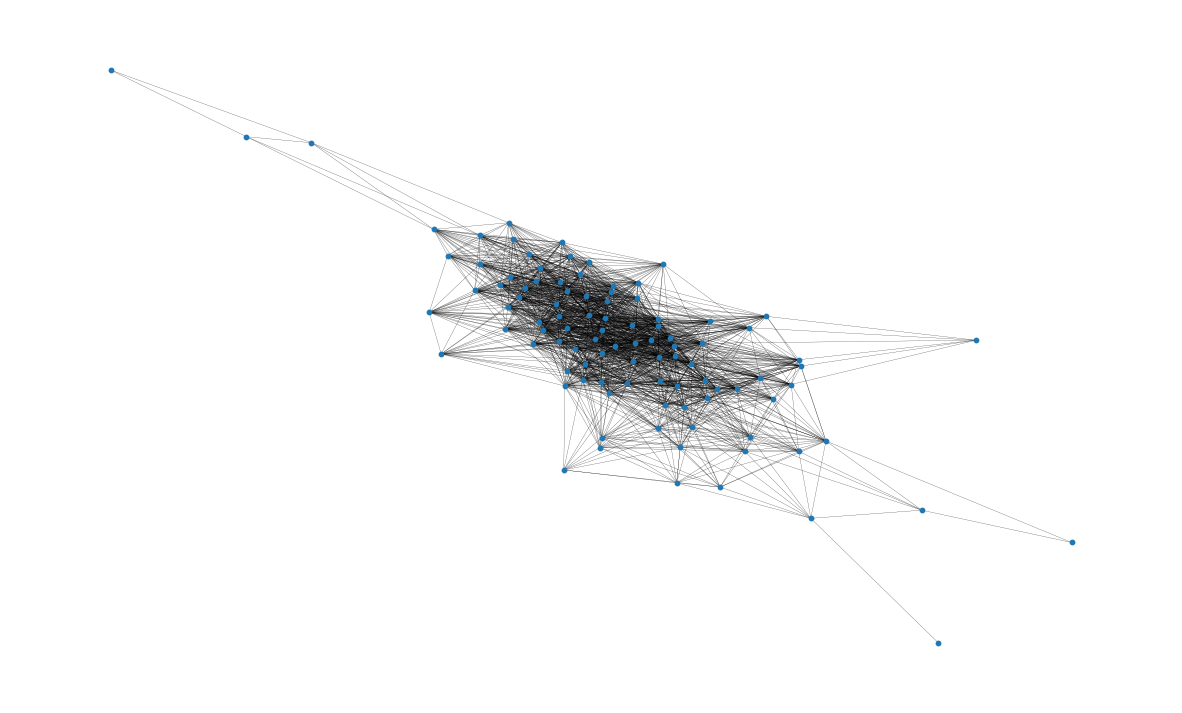

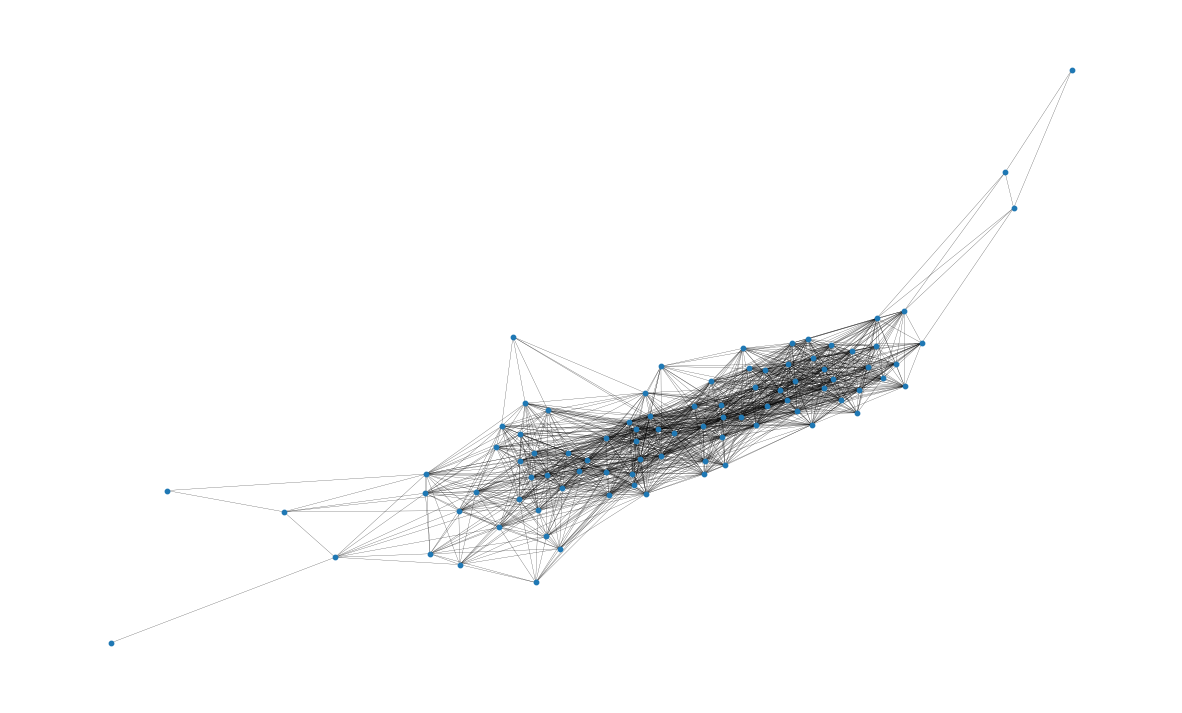

In [14]:
nb_de_noeuds = 10
graph1_minus_high_degree = delete_nodes(graph1.copy(), nb_de_noeuds)
graph2_minus_high_degree = delete_nodes(graph2.copy(), nb_de_noeuds)
graph3_minus_high_degree = delete_nodes(graph3.copy(), nb_de_noeuds)

afficher_graphe_avec_layout(graph1) #arc si distance < 20km
afficher_graphe_avec_layout(graph1_minus_high_degree) #arc si distance < 20km
afficher_graphe_avec_layout(graph2) #arc si distance < 40km
afficher_graphe_avec_layout(graph2_minus_high_degree) #arc si distance < 40km
afficher_graphe_avec_layout(graph3) #arc si distance < 60km
afficher_graphe_avec_layout(graph3_minus_high_degree) #arc si distance < 60km

In [18]:
graphes = [graph1, graph1_minus_high_degree, graph2, graph2_minus_high_degree, graph3, graph3_minus_high_degree]  # remplace par tes graphes réels
noms = ['Graphe <20km', 'Graphe <40km', 'Graphe <60']  # noms pour identification

# Liste pour stocker les résultats
donnees = []

# Boucle sur les graphes
for i in range (0, len(noms)):
    nb_arcs = graphes[i].number_of_edges()
    nb_arcs_after = graphes[i+1].number_of_edges()
    nb_noeuds = graphes[i].number_of_nodes()
    nb_noeuds_after = graphes[i+1].number_of_nodes()
    degre_moyen = np.mean([d for _, d in graphes[i].degree()])
    degre_moyen_after = np.mean([d for _, d in graphes[i+1].degree()])
    
    donnees.append({
        "Nom": noms[i],
        "Nombre d'arcs": nb_arcs,
        "Nombre d'arcs après suppression": nb_arcs_after,
        "Nombre de noeuds": nb_noeuds,
        "Nombre de noeuds après suppression": nb_noeuds_after,
        "Degré moyen des noeuds": degre_moyen,
        "Degré moyen des noeuds après suppression": degre_moyen_after
    })

# Création du DataFrame
result_hd = pd.DataFrame(donnees)

# Affichage
result_hd

Nom  Nombre d'arcs  Nombre d'arcs après suppression  \
0  Graphe <20km            174                              103   
1  Graphe <40km            103                              883   
2    Graphe <60            883                              587   

   Nombre de noeuds  Nombre de noeuds après suppression  \
0               100                                  90   
1                90                                 100   
2               100                                  90   

   Degré moyen des noeuds  Degré moyen des noeuds après suppression  
0                3.480000                                  2.288889  
1                2.288889                                 17.660000  
2               17.660000                                 13.044444